£

In [1]:
from datetime import timedelta
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import psycopg2

conn = psycopg2.connect(dbname="gfmqvpia",
                        user="gfmqvpia",
                        password="NwRoBJ0KJHXmjqUva_7ZW0XOO-qfA26E",
                        host="castor.db.elephantsql.com")

cur = conn.cursor()

Мы колл-центр банка. Сплит операторов, отвечающий за ответы по продуктам клиента. 

1. Клиент звонит, мы идентифицируем его по телефону (phone_number, Personal Data), получаем его ID (uniqueUserId, Personal Data), обращаемся к нему по имени.  
2. Делаем селект через uniqueUserId в табличке с продуктами клиента (User Products) и в табличке с названиями продуктов (Products) отдельно (1) для продуктов, которые у клиента есть и (2) для продуктов, которых у него нет, потому что одна из наших целей – продажи
3. Если мы крутая компания, то интент-рекогнайзер IVR бота понимает тематику обращения и отмечает ее, если не очень, то тематику проставляет оператор, в логи отправляется ключевое слово продукта (productKeyword), начало, конец и длительность звонка +  ID сессии. Телефон мы нигде кроме первой таблички не храним, потому что это персональные данные.
4. В таблице с метриками (Session Metrics) копится аналитика по сессии: CSI – оценка звонка пользователем по пятибалльной шкале + комментарий к ней. Табличка отдельно от логирования самого звонка, потому что оценку ставят в боте а не говорят оператору.  Оценку оставляют не все клиенты, поэтому у оценок уникальный ID
5. В Sales Logging попадают сессии, в которых удалось что-то продать клиенту. Из-за того что продажи происходят не в каждой сессии и в одной сессии могут быть 2 продажи, у таблицы отдельный ключ
6. После каждой сессии, если в Sales Logging обновляется таблица, изменения прилетают и в UserProducts. Через session id мы выбираем userid, через него заполняем строчку в таблице. ProductId оператор не знает, он выбирается по введенному ProductKeyword.  Во время продажи ставим timestamp_end из логирования звонка.

Аггрегация, сортировки (2 балл):

В качестве аггрегации будем выводить число проданных продуктов (можно с условием по датам)

В качестве сортировки можем выбрать число продуктов по пользователям, отсортировать и построить bar plot

SELECT с несколькими (от трех) таблицами в условии выборки (1 балл)

Выбираем всех пользователей, поставивших плохие оценки и смотрим сколько у них продуктов нашей компании. Таблицы Session Metrics, Call Logging, Users Products Гипотеза - пользователи с большим числом продуктов более лояльны

In [3]:
cur.execute("""SELECT * from personal_data
WHERE userid = 224""")

cur.fetchall()

[(224,
  'Максим',
  'Сидорочкин',
  'Макарович',
  '83583878167',
  datetime.date(1990, 11, 6))]

In [4]:
cur.execute("ROLLBACK")

In [5]:
cur.execute("""
SELECT userid,
    CASE WHEN EXTRACT(YEAR FROM AGE(NOW(), dateofbirth)) >= 25 THEN name || ' ' || fathersname
    ELSE name END
FROM personal_data 
WHERE phonenumber = '89321404870';
""")

In [6]:
data = cur.fetchall()

In [7]:
data

[(10, 'Владимир')]

# Запросы для аналитики

## Распределение CSI

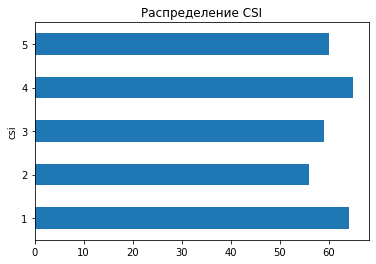

In [89]:
sql_query = pd.read_sql_query ('''
                               SELECT
                               csi, COUNT(csi)
                               FROM session_metrics
                               GROUP BY csi
                               ORDER BY csi ASC''', conn)

df = pd.DataFrame(sql_query, columns = ['csi', 'count'])
df = df.set_index('csi')
df['count'].plot(sort_columns=True, kind='barh', title='Распределение CSI')
plt.show()

## Распределение покупок по каналам

In [90]:
sql_query = pd.read_sql_query("""
    SELECT user_products.saleschannel, products.productname, COUNT(products.productname)

    FROM user_products

    INNER JOIN products ON user_products.productid = products.productid
    GROUP BY 
    user_products.saleschannel,
    products.productname;
    """, conn)

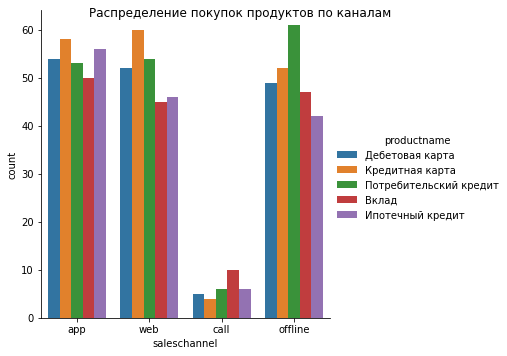

In [91]:
ax = sns.catplot(x = "saleschannel",       # x variable name
            y = "count",       # y variable name
            hue = "productname",  # group variable name
            data = sql_query,     # dataframe to plot
            kind = "bar")
ax.fig.suptitle('Распределение покупок продуктов по каналам')
plt.show()

## Исследование лояльности пользователей

Выбираем всех пользователей, поставивших плохие оценки и смотрим сколько у них продуктов нашей компании. Таблицы Session Metrics, Call Logging, Users Products

In [92]:
cur.execute("""
    SELECT T.userid, T.numprod, Y.avgcsi
    
    FROM
        (SELECT userid, COUNT(salesid) as numprod
        
        FROM user_products
        GROUP BY 
            userid
        ORDER BY numprod DESC
        ) AS T
        
    INNER JOIN
        (SELECT call_logging.userid, PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY session_metrics.csi) as avgcsi
        
        FROM call_logging
        INNER JOIN session_metrics ON call_logging.subsessionid = session_metrics.subsessionid
        GROUP BY
        call_logging.userid
        ) AS Y
    ON T.userid = Y.userid
;""")

In [93]:
csi_data = cur.fetchall()

In [94]:
csi_data

[(154, 4, 2.0),
 (248, 4, 3.0),
 (256, 4, 3.0),
 (300, 4, 5.0),
 (334, 3, 3.5),
 (34, 3, 3.0),
 (94, 3, 3.5),
 (288, 3, 3.5),
 (193, 3, 2.0),
 (453, 3, 2.0),
 (177, 3, 2.0),
 (214, 3, 4.0),
 (147, 3, 1.0),
 (289, 3, 4.0),
 (120, 3, 4.0),
 (187, 3, 1.0),
 (146, 3, 1.0),
 (24, 3, 1.0),
 (106, 3, 1.0),
 (159, 3, 5.0),
 (176, 3, 2.0),
 (309, 3, 2.5),
 (133, 3, 5.0),
 (104, 3, 3.0),
 (140, 3, 3.0),
 (183, 3, 3.0),
 (413, 3, 2.5),
 (391, 3, 3.0),
 (139, 3, 4.0),
 (317, 3, 2.0),
 (312, 3, 2.0),
 (357, 2, 2.0),
 (220, 2, 5.0),
 (2, 2, 3.0),
 (428, 2, 5.0),
 (27, 2, 4.0),
 (415, 2, 2.0),
 (59, 2, 4.0),
 (245, 2, 1.5),
 (39, 2, 4.0),
 (287, 2, 3.0),
 (469, 2, 4.0),
 (118, 2, 1.0),
 (284, 2, 2.0),
 (126, 2, 2.0),
 (12, 2, 3.0),
 (293, 2, 4.0),
 (33, 2, 4.0),
 (185, 2, 5.0),
 (215, 2, 3.0),
 (431, 2, 2.0),
 (462, 2, 2.5),
 (299, 2, 2.5),
 (180, 2, 4.0),
 (236, 2, 4.0),
 (227, 2, 1.0),
 (280, 2, 3.5),
 (239, 2, 2.0),
 (240, 2, 3.0),
 (328, 2, 4.0),
 (297, 2, 5.0),
 (361, 2, 2.0),
 (89, 2, 4.0),
 (2

Гипотеза - пользователи с большим числом продуктов более лояльны

In [95]:
cur.execute("""
    SELECT AVG(sub.avgcsi),
    
    CASE WHEN sub.numprod < 3 THEN '2 и менее продуктов'
    ELSE '3 и более продуктов' END
    FROM
    (SELECT T.userid, T.numprod, Y.avgcsi
    
    FROM
        (SELECT userid, COUNT(salesid) as numprod
        
        FROM user_products
        GROUP BY 
            userid
        ORDER BY numprod DESC
        ) AS T
        
    INNER JOIN
        (SELECT call_logging.userid, PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY session_metrics.csi) as avgcsi
        
        FROM call_logging
        INNER JOIN session_metrics ON call_logging.subsessionid = session_metrics.subsessionid
        GROUP BY
        call_logging.userid
        ) AS Y
    ON T.userid = Y.userid) AS sub
    GROUP BY
    sub.numprod < 3
;""")

In [96]:
cur.fetchall()

[(2.7903225806451615, '3 и более продуктов'),
 (3.0381944444444446, '2 и менее продуктов')]

На наших случайно нагенеренных данных гипотеза не работает

## Число обсужденных продуктов за сессию

Посчитаем среднее число топиков за сессию

In [97]:
sql_query = pd.read_sql_query("""
SELECT T.subsession_count, COUNT(T.subsession_count) as count

FROM (
     SELECT COUNT(subsessionid) as subsession_count
     FROM call_logging
     GROUP BY 
     sessionid
) as T

GROUP BY
T.subsession_count
ORDER BY
count DESC
;""", conn)

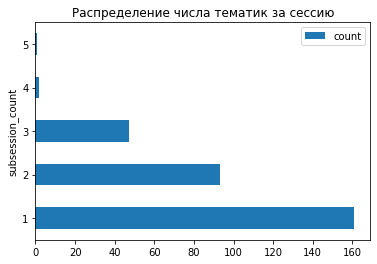

In [98]:
sql_query.set_index('subsession_count').plot(kind='barh', title='Распределение числа тематик за сессию')
plt.show()

# Распределение длительности разговора по продуктам

Нам нужно понять, какое время обслуживания будет для нас целевым, поэтому посмотрим, какое время обслуживание у нас есть сейчас

In [99]:
sql_query = pd.read_sql_query("""
SELECT products.productname, AVG(call_logging.callduration) as avg_duration

FROM call_logging

INNER JOIN products ON call_logging.productkeyword = products.productkeyword

GROUP BY productname

ORDER BY avg_duration DESC""", conn)

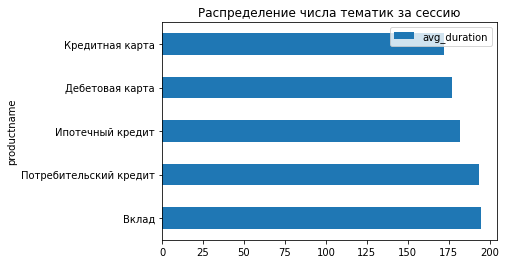

In [100]:
sql_query.set_index('productname').plot(kind='barh', title='Распределение числа тематик за сессию')
plt.show()

# Запрос с условиями по трем таблицам

Найдем пользователей старше 25, кому не понравилось обслуживание по ипотеке

In [101]:
cur.execute("""
SELECT surname || ' ' || name || ' ' || fathersname as client
FROM personal_data
INNER JOIN call_logging ON call_logging.userid = personal_data.userid
INNER JOIN session_metrics ON call_logging.subsessionid = session_metrics.subsessionid

WHERE EXTRACT(YEAR FROM AGE(NOW(), personal_data.dateofbirth)) > 25 
    AND call_logging.productkeyword = 'mortage'
    AND session_metrics.csi < 3""")

In [102]:
cur.fetchall()

[('Васильева Полина Вячеславовна',),
 ('Кононова Милана Викторовна',),
 ('Васютичев Георгий Глебович',),
 ('Фролова Кира Валентиновна',),
 ('Медведева Милана Васильевна',),
 ('Куликова Валерия Андреевна',),
 ('Хлынов Илья Тарасович',),
 ('Величко Константин Юрьевич',),
 ('Никитина Евгения Виталиевна',),
 ('Богданова Ксения Александровна',),
 ('Толстых Марк Вячеславович',),
 ('Некрасова Маргарита Викторовна',),
 ('Раздобарин Тимур Маркович',),
 ('Савина Валерия Викторовна',),
 ('Марушка Тимофей Максимович',),
 ('Бойко Георгий Платонович',),
 ('Варапанов Яков Кириллович',),
 ('Веретельников Виктор Назарович',),
 ('Абрамова Ксения Сергеевна',),
 ('Калашникова Людмила Даниловна',),
 ('Сенчин Лев Матвеевич',),
 ('Кулагина Маргарита Семеновна',),
 ('Шубенок Тимофей Федорович',),
 ('Варапанов Яков Кириллович',),
 ('Лебедева Людмила Тимофеевна',),
 ('Симонова Елизавета Алексеевна',),
 ('Победнов Даниил Данилович',),
 ('Калинников Яков Вадимович',)]

In [103]:
cur.execute("""
SELECT surname || ' ' || name || ' ' || fathersname as client
FROM personal_data
INNER JOIN call_logging ON call_logging.userid = personal_data.userid
INNER JOIN session_metrics ON call_logging.subsessionid = session_metrics.subsessionid
INNER JOIN sales_logging ON call_logging.subsessionid = sales_logging.subsessionid
INNER JOIN products ON sales_logging.productid = products.productid

WHERE EXTRACT(YEAR FROM AGE(NOW(), personal_data.dateofbirth)) > 25 
    AND call_logging.productkeyword = 'mortage'
    AND session_metrics.csi > 3
    AND products.productkeyword = 'mortage'""")

In [104]:
cur.fetchall()

[('Денисова Ева Вячеславовна',)]

# Изменение

In [105]:
cur.execute("""SELECT subsessionid, csi 
FROM session_metrics
ORDER BY subsessionid DESC
LIMIT 1;""")
cur.fetchall()

[(976, 5)]

In [106]:
cur.execute("""UPDATE session_metrics SET csi = 4 WHERE subsessionid = 976;""")

In [107]:
conn.commit()

In [108]:
cur.execute("""SELECT subsessionid, csi 
FROM session_metrics
ORDER BY subsessionid DESC
LIMIT 1;""")
cur.fetchall()

[(976, 4)]

## Удаление

In [ ]:
cur.execute("""DELETE FROM user_products
      WHERE userid = {} AND productid = {};""".format((1, 2)))
conn.commit()